# Ultimate Inc. Data Science Challenge
## DS Notebook

### Import libraries and modify notebook settings

In [1]:
# Import libraries
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from xgboost.sklearn import XGBClassifier

# Modify notebook settings
%matplotlib inline
sns.set(style="whitegrid")
pd.options.display.max_columns = 100
pd.options.display.max_rows = 150

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Create paths to data folders and files

In [2]:
proj_root = os.path.join(os.curdir)

data_dir = os.path.join(proj_root, 'ultimate_challenge')

filepath_logins = os.path.join(data_dir, 'logins.json')

filepath_ultimate = os.path.join(data_dir,
                                 'ultimate_data_challenge.json')


### Read in raw data

In [3]:
df_logins = pd.read_json(filepath_logins)

#df_ultimate = pd.read_json(filepath_ultimate)
data_ultimate = open(filepath_ultimate, 'r').readline()
data_ultimate = json.loads(data_ultimate)
df_ultimate = pd.DataFrame(data_ultimate)

### Part 1 ‐ Exploratory data analysis

The attached `logins.json` file contains (simulated) timestamps of user logins in a particular geographic location. 

Aggregate these login counts based on 15-minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. 

Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [4]:
df_logins.shape

(93142, 1)

In [5]:
df_logins.head(3)

login_time
0 1970-01-01 20:13:18
1 1970-01-01 20:16:10
2 1970-01-01 20:16:37

Are there any null values?

In [6]:
df_logins.isnull().sum()

login_time    0
dtype: int64

No, the series does not contain any null values.

Is the series in chronological order?

In [7]:
df_logins.equals(df_logins.sort_values('login_time'))

False

No.  We will sort the series so that it is in chronological order.

In [8]:
df_logins.sort_values('login_time', inplace=True)

#### Aggregate these login counts based on 15-minute time intervals,

In [9]:
df_grouped_logins = (df_logins.groupby(pd.Grouper(key='login_time',
                                                  freq='15Min'))\
                     ['login_time'].count())

df_grouped_logins = df_grouped_logins.to_frame()

df_grouped_logins.rename(columns={'login_time': 'Login Count'},
                         inplace=True)

df_grouped_logins.index.name = 'Login Bin (15 Minutes)'

Visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. 

In [10]:
one_day = int((24 * 60) / 15)
one_week = 7 * one_day

In [11]:
print('one_day:   {}  periods'.format(one_day))
print('one_week:  {} periods'.format(one_week))

one_day:   96  periods
one_week:  672 periods


In [12]:
df_grouped_logins['Login Count MA (1 Day)'] = \
df_grouped_logins.rolling(window=one_day)['Login Count'].mean()

df_grouped_logins['Login Count MA (1 Week)'] = \
df_grouped_logins.rolling(window=one_week)['Login Count'].mean()

#### Plot the time series of login count based on 15-minute time intervals

'Login Count MA (1 Day)'

'Login Count MA (1 Week)'

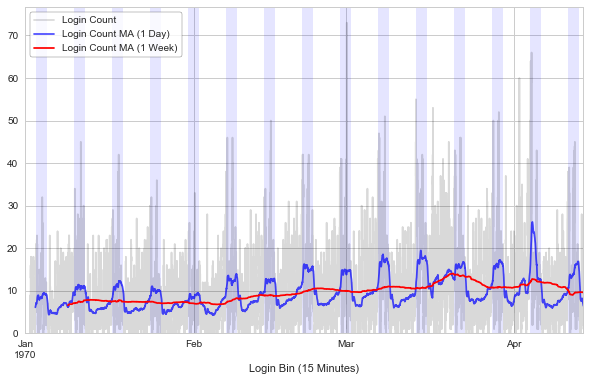

In [13]:
fig, ax = plt.subplots()

df_grouped_logins['Login Count'].\
plot(figsize=(10, 6), color='k', alpha=0.15, ax=ax)

df_grouped_logins['Login Count MA (1 Day)'].\
plot(figsize=(10, 6), color='b', alpha=0.7, ax=ax)

df_grouped_logins['Login Count MA (1 Week)'].\
plot(figsize=(10, 6), color='r', alpha=1, ax=ax)

ax.set_ylim(bottom=0)
ax.set_xlim(left=pd.Timestamp(df_grouped_logins.index[0].date()))

# Highlight weekends
weekends = df_grouped_logins[df_grouped_logins.\
                             index.dayofweek >= 5].index

delta = df_grouped_logins.index[1] - df_grouped_logins.index[0]

for i in range(len(weekends)-1):
     ax.axvspan(weekends[i], weekends[i] + delta, 
                facecolor='blue', edgecolor='none', alpha=.1)

legend = ax.legend(loc='upper left', frameon=True)
frame = legend.get_frame()
frame.set_facecolor('w')
frame.set_edgecolor('k')

# Save the figure
plt.savefig('login_counts_time_series', dpi = 300,
            bbox_inches='tight')

#### Create boxplot of daily login counts

In [14]:
df_grouped_logins_1D = (df_logins.groupby(pd.Grouper(key='login_time',
                                                     freq='1D'))\
                        ['login_time'].count())

df_grouped_logins_1D = df_grouped_logins_1D.to_frame()

df_grouped_logins_1D.rename(columns={'login_time': 'Login Count (Daily)'},
                         inplace=True)

df_grouped_logins_1D.index.name = 'Login Bin (1 Day)'

df_grouped_logins_1D['Day'] = (df_grouped_logins_1D.index.weekday_name)

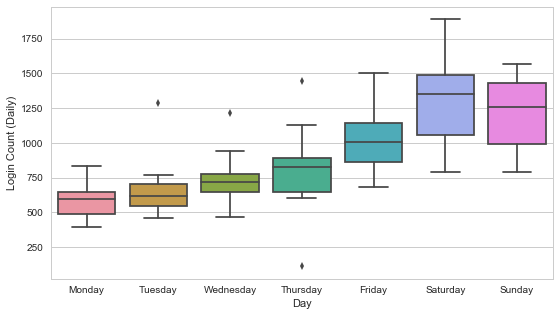

In [15]:
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday',
                 'Friday', 'Saturday', 'Sunday']

fig, ax = plt.subplots(figsize=(9, 5))

sns.boxplot(x='Day', y='Login Count (Daily)',
            data=df_grouped_logins_1D, order=weekday_order, ax=ax)

# Save the figure
plt.savefig('login_counts_box_plot_day', dpi = 300, bbox_inches='tight')

#### Create boxplot of hourly login counts

In [16]:
df_grouped_logins_1H = (df_logins.groupby(pd.Grouper(key='login_time',
                                                     freq='1H'))\
                        ['login_time'].count())

df_grouped_logins_1H = df_grouped_logins_1H.to_frame()

df_grouped_logins_1H.rename(columns={'login_time': 'Login Count (Hourly)'},
                         inplace=True)

df_grouped_logins_1H.index.name = 'Login Bin (1 Hour)'

df_grouped_logins_1H['Hour'] = (df_grouped_logins_1H.index.hour)

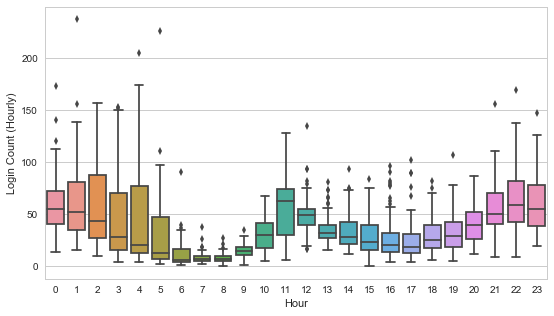

In [17]:
hour_order = list(df_grouped_logins_1H.index.hour.unique().sort_values())

fig, ax = plt.subplots(figsize=(9, 5))

sns.boxplot(x='Hour', y='Login Count (Hourly)',
            data=df_grouped_logins_1H, order=hour_order, ax=ax)

# Save the figure
plt.savefig('login_counts_box_plot_hour', dpi = 300, bbox_inches='tight')

##  Part 3 ‐ Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file `ultimate_data_challenge.json`. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long-term rider retention (again, a few sentences will suffice).


### 1. Data Wrangling & EDA
#### Data Wrangling

In [18]:
df_ultimate.shape

(50000, 12)

In [19]:
df_ultimate.head()

avg_dist  avg_rating_by_driver  avg_rating_of_driver  avg_surge  \
0      3.67                   5.0                   4.7       1.10   
1      8.26                   5.0                   5.0       1.00   
2      0.77                   5.0                   4.3       1.00   
3      2.36                   4.9                   4.6       1.14   
4      3.13                   4.9                   4.4       1.19   

             city last_trip_date    phone signup_date  surge_pct  \
0  King's Landing     2014-06-17   iPhone  2014-01-25       15.4   
1         Astapor     2014-05-05  Android  2014-01-29        0.0   
2         Astapor     2014-01-07   iPhone  2014-01-06        0.0   
3  King's Landing     2014-06-29   iPhone  2014-01-10       20.0   
4      Winterfell     2014-03-15  Android  2014-01-27       11.8   

   trips_in_first_30_days  ultimate_black_user  weekday_pct  
0                       4                 True         46.2  
1                       0                False         50.0  
2                       3                False        100.0  
3                       9                 True         80.0  
4                      14                False         82.4

Wrangle date variables.

In [20]:
df_ultimate['last_trip_date'].dtype

dtype('O')

In [21]:
df_ultimate['signup_date'].dtype

dtype('O')

In [22]:
df_ultimate['last_trip_date'] = \
pd.to_datetime(df_ultimate['last_trip_date'])

In [23]:
df_ultimate['signup_date'] = \
pd.to_datetime(df_ultimate['signup_date'])

Wrangle boolean variables.

In [24]:
df_ultimate['ultimate_black_user'] = (df_ultimate['ultimate_black_user']\
                                      .astype(int))

#### Engineer new features.

In [25]:
df_ultimate['signup_dayofweek'] = df_ultimate['signup_date'].dt.dayofweek

#### Create the response variable.

In [26]:
delta = df_ultimate['last_trip_date'] - df_ultimate['signup_date']

last_active_month = (np.floor(delta / np.timedelta64(1,
                                                    'M')).\
                     astype(int) + 1)

df_ultimate['y'] = (last_active_month == 6).astype(int)

Move the response variable to the leftmost column.

In [27]:
col_names = list(df_ultimate.columns)
col_names.insert(0, col_names.pop(col_names.index('y')))
df_ultimate = df_ultimate.loc[:, col_names]

#### Drop certain features

We drop the `last_trip_date` variable.  It was used to calculate the response variable. This variable could not be known ahead of time, and it cannot be used to predict the response variable.

In [28]:
df_ultimate.drop('last_trip_date', axis=1,  inplace=True)

We also drop the `signup_date` variable.  It too was used to calculate the response variable. 

In [29]:
df_ultimate.drop('signup_date', axis=1,  inplace=True)

#### One-hot-encode certain features

In [30]:
df_ultimate.head(3)

y  avg_dist  avg_rating_by_driver  avg_rating_of_driver  avg_surge  \
0  0      3.67                   5.0                   4.7        1.1   
1  0      8.26                   5.0                   5.0        1.0   
2  0      0.77                   5.0                   4.3        1.0   

             city    phone  surge_pct  trips_in_first_30_days  \
0  King's Landing   iPhone       15.4                       4   
1         Astapor  Android        0.0                       0   
2         Astapor   iPhone        0.0                       3   

   ultimate_black_user  weekday_pct  signup_dayofweek  
0                    1         46.2                 5  
1                    0         50.0                 2  
2                    0        100.0                 0

In [31]:
drop_list = list(df_ultimate.select_dtypes(include=['object']).columns)
drop_list

['city', 'phone']

One-hot-encode `city` and `phone`

In [32]:
df_ultimate = pd.get_dummies(df_ultimate, columns=drop_list)

In [33]:
df_ultimate.head(3)

y  avg_dist  avg_rating_by_driver  avg_rating_of_driver  avg_surge  \
0  0      3.67                   5.0                   4.7        1.1   
1  0      8.26                   5.0                   5.0        1.0   
2  0      0.77                   5.0                   4.3        1.0   

   surge_pct  trips_in_first_30_days  ultimate_black_user  weekday_pct  \
0       15.4                       4                    1         46.2   
1        0.0                       0                    0         50.0   
2        0.0                       3                    0        100.0   

   signup_dayofweek  city_Astapor  city_King's Landing  city_Winterfell  \
0                 5             0                    1                0   
1                 2             1                    0                0   
2                 0             1                    0                0   

   phone_Android  phone_iPhone  
0              0             1  
1              1             0  
2              0             1

Check for null values

In [34]:
df_ultimate.isnull().sum()

y                            0
avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
surge_pct                    0
trips_in_first_30_days       0
ultimate_black_user          0
weekday_pct                  0
signup_dayofweek             0
city_Astapor                 0
city_King's Landing          0
city_Winterfell              0
phone_Android                0
phone_iPhone                 0
dtype: int64

#### What fraction of the observed users were retained?

What fraction of the observed users were retained (*i.e*., still active in their 6th month on the system)?

In [35]:
df_ultimate['y'].value_counts(normalize=True)

0    0.77612
1    0.22388
Name: y, dtype: float64

About 22% of the observed users were retained.

### 2. Build a predictive model

Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

In [36]:
df_ultimate.head()

y  avg_dist  avg_rating_by_driver  avg_rating_of_driver  avg_surge  \
0  0      3.67                   5.0                   4.7       1.10   
1  0      8.26                   5.0                   5.0       1.00   
2  0      0.77                   5.0                   4.3       1.00   
3  1      2.36                   4.9                   4.6       1.14   
4  0      3.13                   4.9                   4.4       1.19   

   surge_pct  trips_in_first_30_days  ultimate_black_user  weekday_pct  \
0       15.4                       4                    1         46.2   
1        0.0                       0                    0         50.0   
2        0.0                       3                    0        100.0   
3       20.0                       9                    1         80.0   
4       11.8                      14                    0         82.4   

   signup_dayofweek  city_Astapor  city_King's Landing  city_Winterfell  \
0                 5             0                    1                0   
1                 2             1                    0                0   
2                 0             1                    0                0   
3                 4             0                    1                0   
4                 0             0                    0                1   

   phone_Android  phone_iPhone  
0              0             1  
1              1             0  
2              0             1  
3              0             1  
4              1             0

#### Train test split

In [37]:
df = df_ultimate

In [38]:
# Extract X and y from df
X = df.drop('y', axis=1).values
y = df['y'].values

# Train test split
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=42)

#### Define the pipeline

In [39]:
# Create pipeline
pipe = Pipeline([('classifier', 
                  XGBClassifier(objective='binary:logistic'))])

# Create parameter grid
param_grid = [
    {'classifier': [XGBClassifier(objective='binary:logistic')], 
     'classifier__n_estimators': [200]}]

#### Perform the grid search

In [40]:
# Set verbosity
verbosity = 1

# Execute Grid search
grid = GridSearchCV(pipe, param_grid, cv=3, scoring='roc_auc',
                    verbose=verbosity)#, n_jobs=cores_used)

# Set seed for reproducibility
np.random.seed(42)

# Fit the grid search object
grid.fit(X_train, y_train)

print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.3f}".format(grid.best_score_))

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.9s finished


Best params:
{'classifier': XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=200, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1), 'classifier__n_estimators': 200}

Best cross-validation score: 0.818


#### Analyze model results

In [41]:
clf = grid.best_estimator_

In [42]:
roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

0.81890217684888911

In [43]:
confusion_matrix(y_train, clf.predict(X_train))

array([[25516,  1639],
       [ 4826,  3019]])

In [44]:
confusion_matrix(y_test, clf.predict(X_test))

array([[10916,   735],
       [ 2138,  1211]])

#### Feature Importance

Identify the relative importance of each feature and plot relative feature importance.

In [45]:
features_importance = pd.Series(clf.steps[0][1].feature_importances_,
                                index=df.drop('y', axis=1).columns)

features_importance.sort_values(ascending=False, inplace=True)

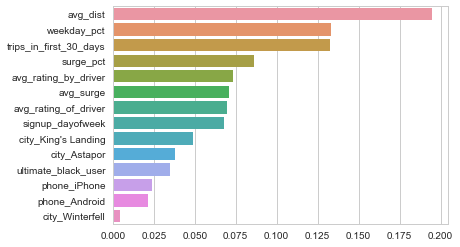

In [46]:
sns.barplot(y=features_importance.index,
            x=features_importance.values)

# Save the figure
plt.savefig('feature_importance', dpi = 300, bbox_inches='tight')

In [47]:
#def partial_dependency(model, X, features, selected_feature, floor):
def partial_dependency_2d(model, X, selected_feature_1=0,
                          selected_feature_2=7):
     # The model could be an XGBoost sklearn fitted instance (or anything else with a 
    # predict method)
    X_temp = X.copy()

    grid_1 = np.linspace(np.percentile(X_temp[:, selected_feature_1], 0.1), 
                         np.percentile(X_temp[:, selected_feature_1], 99.5), 
                         50)
    grid_2 = np.linspace(np.percentile(X_temp[:, selected_feature_2], 0.1), 
                         np.percentile(X_temp[:, selected_feature_2], 99.5), 
                         50)

    XX_1, XX_2 = np.meshgrid(grid_1, grid_2)
    
    y_pred = np.zeros(XX_1.shape)
    
    for i in range(XX_1.shape[0]):
        for j in range(XX_2.shape[1]):
            X_temp[:, selected_feature_1] = grid_1[i]
            X_temp[:, selected_feature_2] = grid_2[j]

            y_pred[i, j] = model.predict(X_temp).mean()
    
    return XX_1, XX_2, y_pred

In [48]:
clf = grid.best_estimator_

XX_1, XX_2, y_pred = partial_dependency_2d(clf, X_train,
                                       selected_feature_1=0,
                                       selected_feature_2=7)

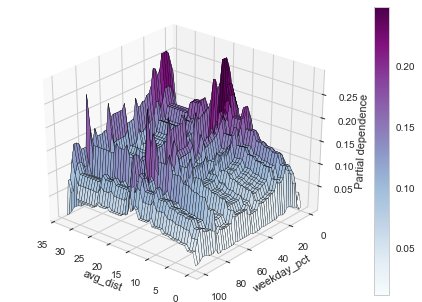

In [49]:
column_names = df.drop('y', axis=1).columns
column_names = np.array(column_names)
column_names

fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_surface(XX_1, XX_2, y_pred, rstride=1, cstride=1,
                       cmap=plt.cm.BuPu, edgecolor='k')
ax.set_xlabel(column_names[0])
ax.set_ylabel(column_names[7])
ax.set_zlabel('Partial dependence')
#  pretty init view
ax.view_init(elev=30, azim=130)
plt.colorbar(surf)

# Save the figure
plt.savefig('Partial_dependence', dpi = 300,
            bbox_inches='tight')

#### Other
#### Fraction of users retained by phone

Is there a apple/android problem?

In [50]:
df_temp = pd.DataFrame(data_ultimate)

df_phone = df_ultimate[['y']].join(df_temp[['phone']])

df_phone = df_phone.groupby(by=['phone', 'y'])['y'].count().unstack()

In [51]:
df_phone

y            0     1
phone               
Android  13273  1749
iPhone   25214  9368

#### Fraction of users retained by phone

In [52]:
df_phone[1].div(df_phone[0] + df_phone[1])

phone
Android    0.116429
iPhone     0.270892
dtype: float64

#### Resample fraction of users retained by phone

In [53]:
df_temp = pd.DataFrame(data_ultimate)

df_phone = df_ultimate[['y']].join(df_temp[['phone']])

In [54]:
n_samples = 500 #len(df_phone)

iters = 1000

phone_array = np.zeros((iters,2))

for i in range(iters):

    df_phone_sample = (df_phone.sample(n=n_samples,
                                       replace=True).\
                       groupby(by=['phone',
                                   'y'])['y'].count().unstack())

    temp_series = df_phone_sample[1].div(df_phone_sample[0] + \
                                         df_phone_sample[1])
    
    phone_array[i] = temp_series.values

    
df_phone_sample = pd.DataFrame(phone_array, columns=temp_series.index)

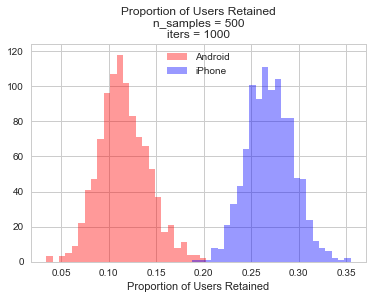

In [55]:
sns.distplot(df_phone_sample['Android'], kde=False, label='Android', color='r')
sns.distplot(df_phone_sample['iPhone'], kde=False, label='iPhone', color='b')
plt.legend(loc='upper center')
plt.xlabel('Proportion of Users Retained')
plt.title('Proportion of Users Retained\n' + 
          'n_samples = {}\n'.format(str(n_samples)) +
          'iters = {}'.format(str(iters)))

# Save the figure
plt.savefig('proportion_retained_by_phone', dpi = 300, 
            bbox_inches='tight')